<a href="https://colab.research.google.com/github/aa25desh/graph/blob/master/CRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from matplotlib import pyplot as plt
import numpy as np

In [0]:
SEED = 5132290 # from random.org
np.random.seed(SEED)

In this notebook we will see basic iplementation of Chinese Restaurant Process.

I assume that reader has gone through ttps://docs.pymc.io/notebooks/dp_mix.html
    
which spans form Dirichlet process 𝑃 ∼ DP(𝛼,𝑃0) property that from every

disjoint pratition 𝑆1,…,𝑆𝑛 of Ω (𝑃(𝑆1),…,𝑃(𝑆𝑛)) ∼ Dir(𝛼𝑃0(𝑆1),…,𝛼𝑃0(𝑆𝑛))

... to the stick breaking process 𝑃 = ∑𝑤𝑖𝛿𝜔𝑖 ∼ DP(𝛼,𝑃0)

So Stick breaking process solves problem of fixing the Number of cluster in advanced 

of Dirichlet by using the w1,..,wk ... ∼ GEM(𝛼) 

i.e To do so we have to sample beta K times 𝛽1,…,𝛽𝐾 ∼ Beta(1,𝛼)

w1 ∼ Beta(a1, a2) and Zn ∼ Cat(w1, w2) Where Zi i=1:N Data observed
    
If New data comes then, what is the probability that it belong to cluster W1 ,

For that we Integrate out frequency P(Zn=1/Z1,Z2..Zn-1) = a1,n /(a1,n + a2,n)

Where ai,n := ai + ∑ 1{Zm=i}
    
Above exercise is similar to drawing a ball from PolyUrn (having two balls)

so we choose any ball with equal probability and Replace and add the ball of same colour.

for example we have Urn with some pink and black balls Lt n->Inf

#pink/#total = Wpink & Wpink 

Wpink & Wpink = Beta(a_pink, a_black)

Here if we repeat steps for multivariate, We would arrive at similar result

for example we have Urn with some pink, black, blue & red balls

Lt n->Inf (#pink, #black, #blue, #red)/#total = Wpink, Wblack, Wblue, Wred

Wpink, Wblack, Wblue, Wred = Dirichlet(a_pink, a_black, Wpink, a_blue, a_red)

We have PolyUrn draws following Dirichlet Distribution.
Moving towards the Hoppe urn/ Blackwell-MacQueen urn We choose a ball proportional
to its mass
if Black (this ball exist form frist draw has mass 𝛼) is choosen,
we replace and add ball of new colour
Else replace and add the ball of same colour

(#first_ball, #all_other) = PolyUrn(1, 𝛼) = B1 
    
(#second_ball, #all_othe) = PolyUrn(1, 𝛼) = B2 . . 
    
This imply we can use stick breking here too. w1, w2, ... = B1, B2(1-B1) ...

Whaterever we are doing with polyUrn is same are the Chinese Restaurant Process 

Each customer walks in

1> sits at existing table with probability proportional to number of #people there

2> Froms new table with probability 𝛼

Marginal for the catogorical likelihood with prior GEM(1, 𝛼) is Partation

for example

A8 = {{1, 2, 7, 8}, {3, 6, 5}, {4}}

probability of seating is 𝛼/𝛼 * 1/(1 + 𝛼) * 𝛼/(2 + 𝛼) * 𝛼/(3 + 𝛼) * 1/(4 + 𝛼) * 2/(5 + 𝛼) * 2/(6 + 𝛼) * 3/(7 + 𝛼)

p(An | An,-x) = 

1> #C/(n + 𝛼 -1) if x joins cluster C

2> 𝛼 /(n + 𝛼 -1) if x froms new cluster

In [0]:
class CRPprocess:
    def __init__(self, alpha):
        assert alpha > 0, "alpha is positive Number"
        self.alpha = alpha
        self.cumfreq = np.ones(1)
        self.customernum = 1
        self.tablenum = 1
        
    def newcustomer(self):
        N = self.customernum
        randnum = (float(N) + self.alpha)*np.random.uniform(
                                                 low=0.0, high=1.0, size=1)
        pos = np.searchsorted(self.cumfreq, randnum, side='left')
        if randnum > N:
            self.cumfreq = np.append(self.cumfreq, N + 1)
            self.tablenum += 1
        else: 
            zerovec = np.zeros(pos)
            onevec = np.ones(self.cumfreq.size - pos)
            self.cumfreq += np.append(zerovec, onevec)
        self.customernum += 1 
        
    def tables(self):
        tablefreq = np.zeros(self.cumfreq.size)
        tablefreq[0] = self.cumfreq[0]
        for i in range(1, self.cumfreq.size):
            tablefreq[i] = self.cumfreq[i] - self.cumfreq[i-1]
        return tablefreq
    
    def newcustomers(self, N):
        for i in range(N):
            self.newcustomer()
    

In [0]:
# Here I from the lsit of w1, w2, w3 .... for Fifty chains
import random
aplha = 50
numOfchain = 50
N = 1000 #Number of customer
Res = [CRPprocess(aplha) for i in range(numOfchain)]
[i.newcustomers(N) for i in Res]
Res = [i.tables()/N for i in Res]
random.shuffle(Res)
Res

[array([0.005, 0.031, 0.008, 0.009, 0.009, 0.018, 0.028, 0.006, 0.022,
        0.002, 0.013, 0.004, 0.011, 0.008, 0.035, 0.041, 0.014, 0.024,
        0.025, 0.011, 0.002, 0.005, 0.009, 0.005, 0.006, 0.003, 0.02 ,
        0.016, 0.002, 0.007, 0.001, 0.016, 0.007, 0.016, 0.019, 0.003,
        0.011, 0.001, 0.017, 0.01 , 0.003, 0.007, 0.01 , 0.019, 0.012,
        0.001, 0.014, 0.003, 0.008, 0.02 , 0.003, 0.002, 0.018, 0.003,
        0.009, 0.021, 0.007, 0.008, 0.004, 0.016, 0.005, 0.003, 0.012,
        0.001, 0.001, 0.003, 0.002, 0.002, 0.003, 0.007, 0.001, 0.005,
        0.005, 0.001, 0.004, 0.001, 0.006, 0.003, 0.009, 0.003, 0.003,
        0.002, 0.007, 0.004, 0.012, 0.001, 0.002, 0.005, 0.002, 0.001,
        0.016, 0.011, 0.009, 0.006, 0.012, 0.003, 0.004, 0.01 , 0.001,
        0.002, 0.006, 0.001, 0.001, 0.008, 0.006, 0.002, 0.004, 0.001,
        0.002, 0.002, 0.005, 0.003, 0.001, 0.009, 0.004, 0.003, 0.001,
        0.002, 0.001, 0.001, 0.001, 0.007, 0.002, 0.002, 0.001, 0.001,
      

In [0]:
# cdf addups to one 
largest = max([len(i) for i in Res])
cdf = [np.append(i, np.zeros(largest - len(i))) for i in Res]
cdf = [i.cumsum() for i in cdf] # Reshaped all the Chain into same size
cdf 

[array([0.005, 0.036, 0.044, 0.053, 0.062, 0.08 , 0.108, 0.114, 0.136,
        0.138, 0.151, 0.155, 0.166, 0.174, 0.209, 0.25 , 0.264, 0.288,
        0.313, 0.324, 0.326, 0.331, 0.34 , 0.345, 0.351, 0.354, 0.374,
        0.39 , 0.392, 0.399, 0.4  , 0.416, 0.423, 0.439, 0.458, 0.461,
        0.472, 0.473, 0.49 , 0.5  , 0.503, 0.51 , 0.52 , 0.539, 0.551,
        0.552, 0.566, 0.569, 0.577, 0.597, 0.6  , 0.602, 0.62 , 0.623,
        0.632, 0.653, 0.66 , 0.668, 0.672, 0.688, 0.693, 0.696, 0.708,
        0.709, 0.71 , 0.713, 0.715, 0.717, 0.72 , 0.727, 0.728, 0.733,
        0.738, 0.739, 0.743, 0.744, 0.75 , 0.753, 0.762, 0.765, 0.768,
        0.77 , 0.777, 0.781, 0.793, 0.794, 0.796, 0.801, 0.803, 0.804,
        0.82 , 0.831, 0.84 , 0.846, 0.858, 0.861, 0.865, 0.875, 0.876,
        0.878, 0.884, 0.885, 0.886, 0.894, 0.9  , 0.902, 0.906, 0.907,
        0.909, 0.911, 0.916, 0.919, 0.92 , 0.929, 0.933, 0.936, 0.937,
        0.939, 0.94 , 0.941, 0.942, 0.949, 0.951, 0.953, 0.954, 0.955,
      

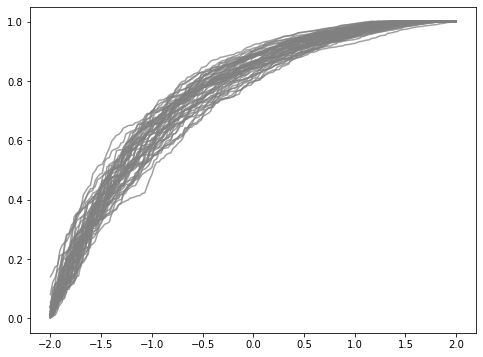

In [0]:
x_plot = np.linspace(-2, 2, largest)
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(numOfchain):
    ax.plot(x_plot, cdf[i], c='gray', alpha=0.75);